In [1]:
import logging
import cabinetry

We customize the output from `cabinetry` to achieve the desired verbosity.
This is optional.

In [2]:
logging.basicConfig(
    level=logging.INFO, format="%(levelname)s - %(name)s - %(message)s"
)
logging.getLogger("matplotlib").setLevel(logging.WARNING)

Download a workspace from HEPData, extract it, pick a signal with `pyhf patchset apply`. We use a workspace from an ATLAS search for bottom-squark pair production: [JHEP 12 (2019) 060](https://atlas.web.cern.ch/Atlas/GROUPS/PHYSICS/PAPERS/SUSY-2018-31/). The corresponding HEPData entry is [10.17182/hepdata.89408.v3](https://doi.org/10.17182/hepdata.89408.v3).

In [3]:
from pyhf.contrib.utils import download

download("https://www.hepdata.net/record/resource/1935437?view=true", "bottom-squarks")
!pyhf patchset apply bottom-squarks/RegionC/BkgOnly.json bottom-squarks/RegionC/patchset.json\
--name sbottom_600_280_150 --output-file bottom-squarks.json

The `bottom-squarks.json` workspace is now ready to be used. We will run a maximum likelihood fit with `cabinetry` and visualize the results. First, we have a brief look at the content of the workspace:

In [4]:
!pyhf inspect bottom-squarks.json | head -n 6

                                     Summary       
                               ------------------  
                                  channels  3
                                   samples  9
                                parameters  63
                                 modifiers  63


The fit model specified in the workspace is created next.

In [5]:
ws = cabinetry.workspace.load("bottom-squarks.json")
model, data = cabinetry.model_utils.model_and_data(ws)

INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier lumi (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier staterror_CRtt_cuts (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier SigRad (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier mu_SIG (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier EL_EFF_ChargeIDSel_TOTAL_1NPCOR_PLUS_UNCOR (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier EL_EFF_ID_TOTAL_1NPCOR_PLUS_UNCOR (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier EL_EFF_Iso_TOTAL_1NPCOR_PLUS_UNCOR (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier EL_EFF_Reco_TOTAL_1NPCOR_PLUS_UNCOR (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier EL_EFF_TriggerEff_TOTAL_1NPCOR_PLUS_UNCOR (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier EL_EFF_Trigger_TOTAL_1NPCOR_PLUS_UNCOR (1 new n

We can take a look at a yield table for this model and visualize the distributions we are going to fit.

In [6]:
cabinetry.visualize.data_MC(model, data)

INFO - cabinetry.visualize - generating pre-fit yield table
INFO - cabinetry.tabulate - yields per bin:
╒═════════════════════╤═══════════════╤══════════════╤═══════════════╤══════════════╤═════════════╤═════════════╕
│ sample              │ CRtt_cuts     │ CRz_cuts     │ SR_metsigST   │              │             │             │
│                     │ bin 1         │ bin 1        │ bin 1         │ bin 2        │ bin 3       │ bin 4       │
╞═════════════════════╪═══════════════╪══════════════╪═══════════════╪══════════════╪═════════════╪═════════════╡
│ W                   │ 17.26         │ 0.00         │ 2.16          │ 0.63         │ 0.24        │ 0.42        │
├─────────────────────┼───────────────┼──────────────┼───────────────┼──────────────┼─────────────┼─────────────┤
│ Z                   │ 0.32          │ 53.18        │ 8.77          │ 5.91         │ 1.98        │ 1.12        │
├─────────────────────┼───────────────┼──────────────┼───────────────┼──────────────┼─────────────

Take a look at the `figures/` folder to see the visualizations, or see below.
We convert the `.pdf` figure to `.png` for viewing in this notebook via `ghostscript`.

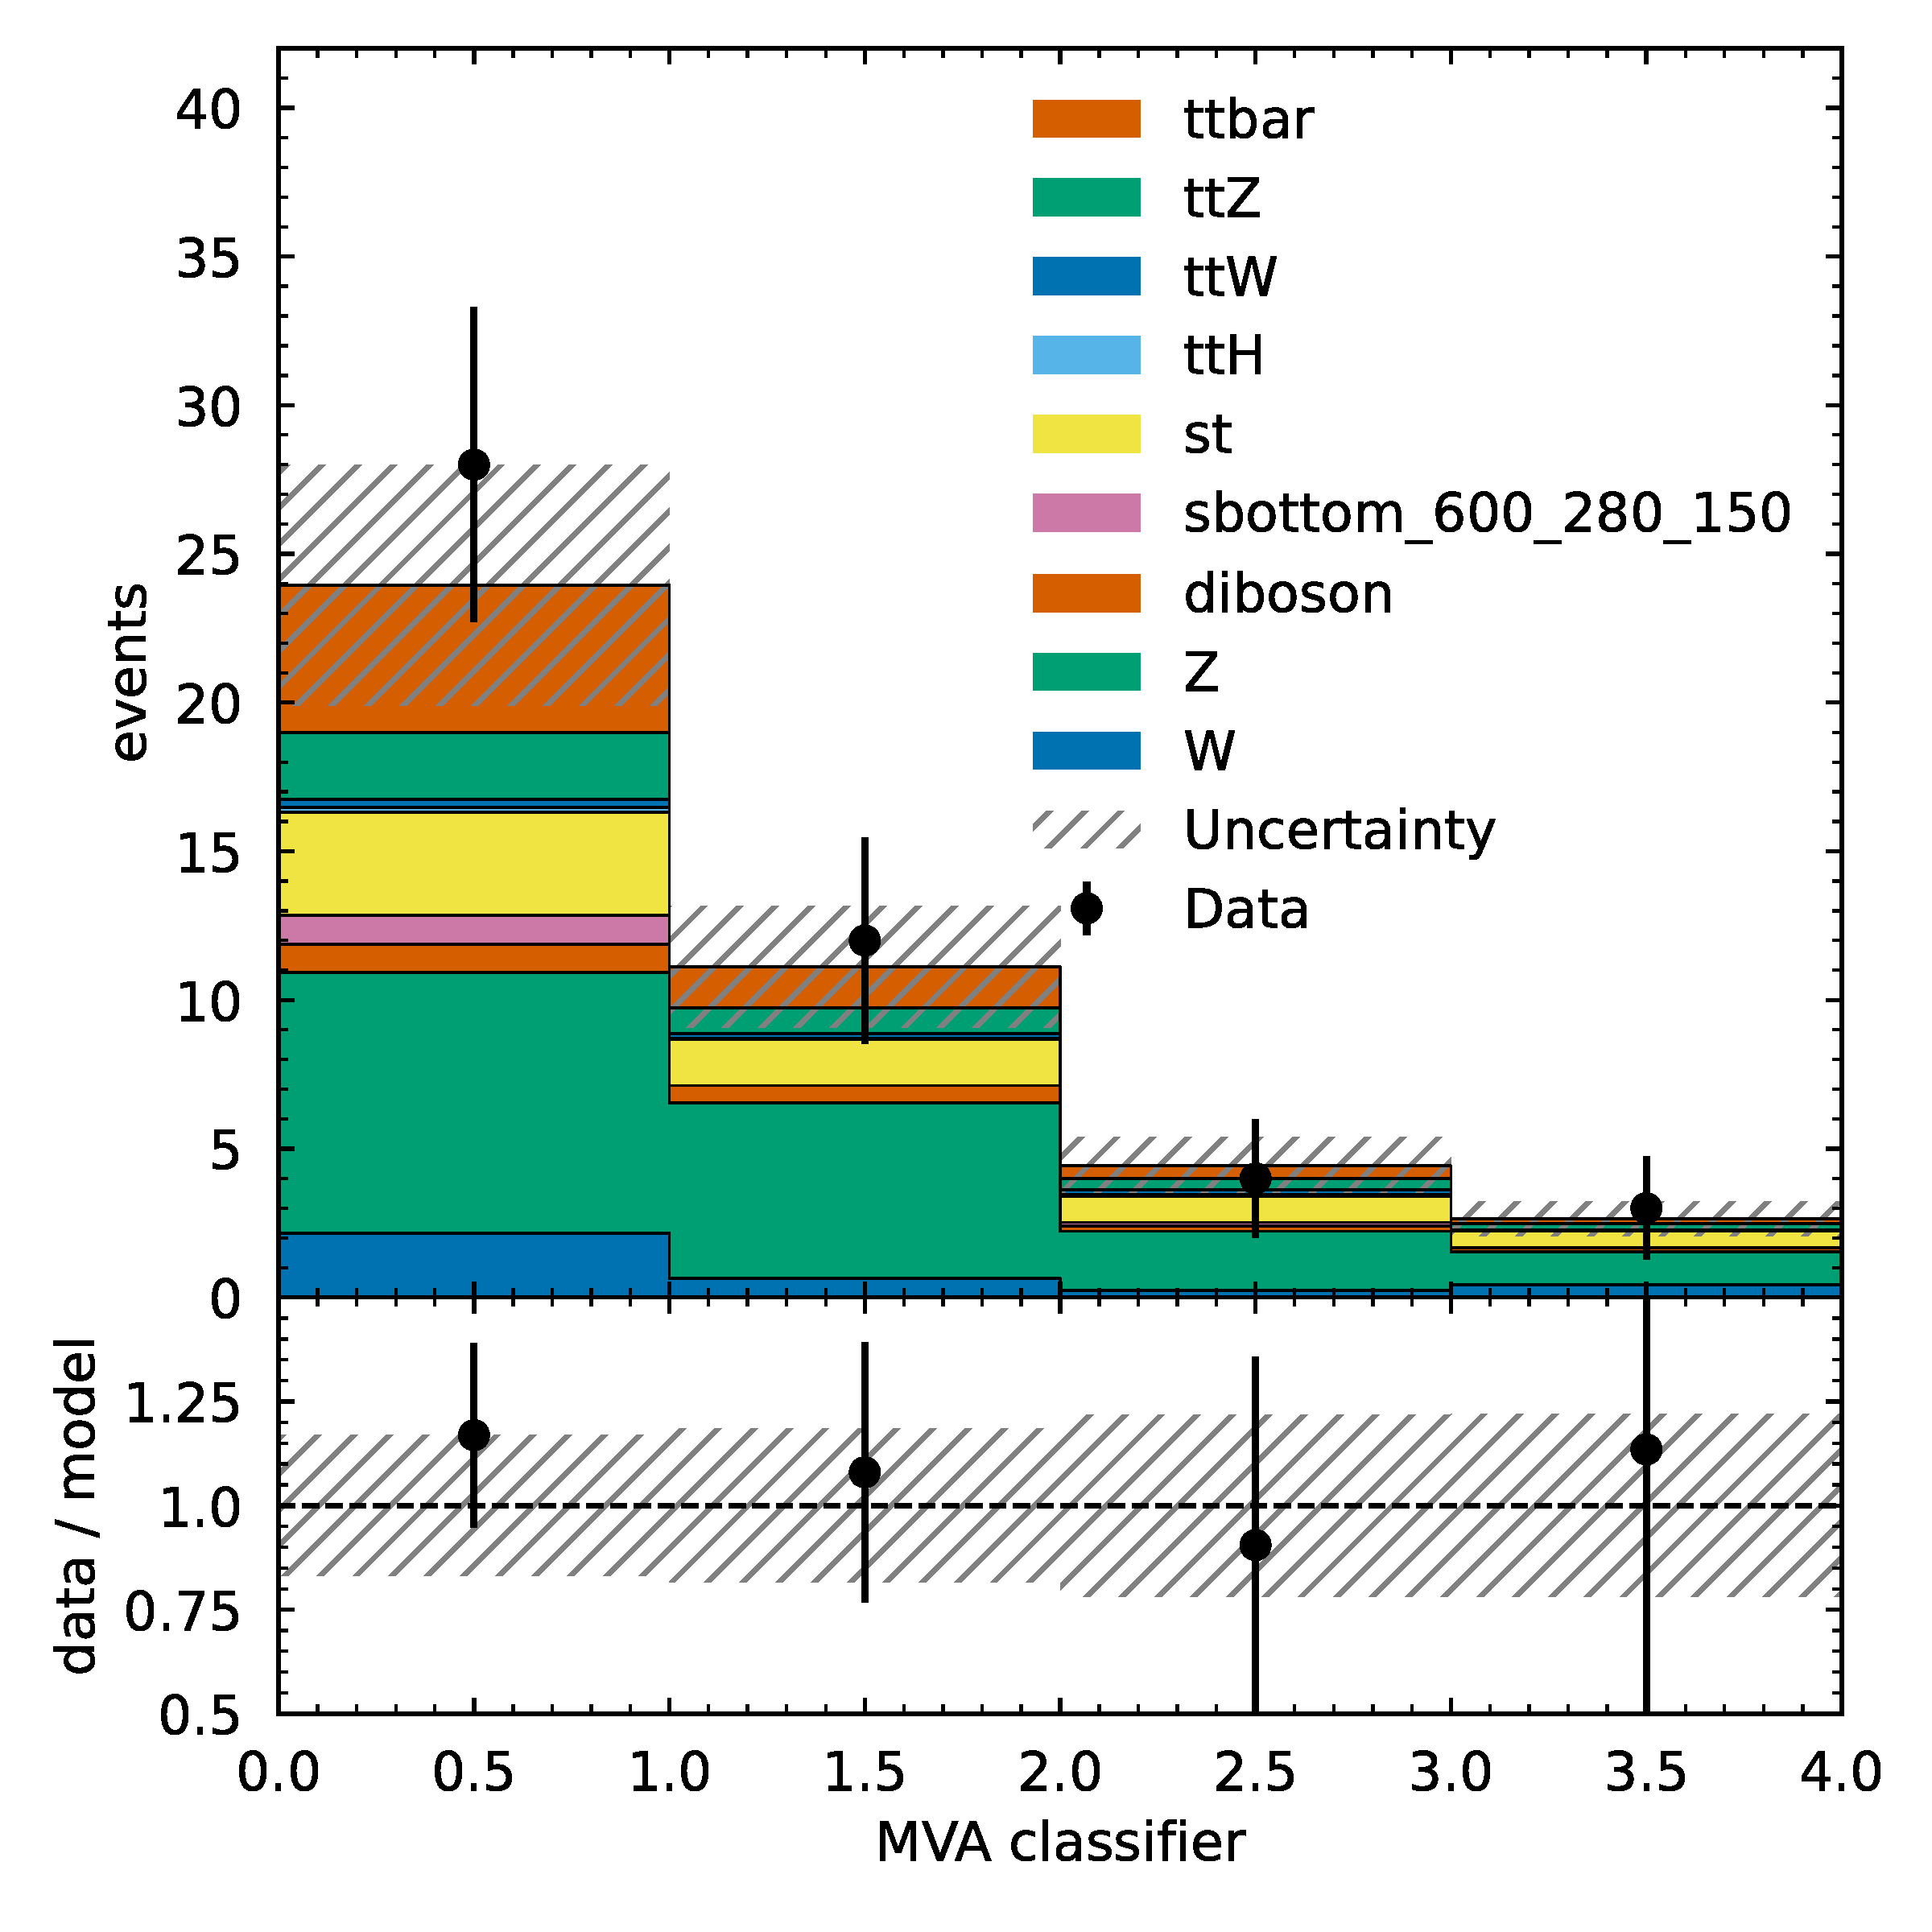

In [7]:
from IPython.display import Image
!gs -dSAFER -dBATCH -dNOPAUSE -dQUIET -sDEVICE=png16m -r400\
-sOutputFile="figures/SR_metsigST_prefit.png" "figures/SR_metsigST_prefit.pdf"
Image("figures/SR_metsigST_prefit.png", width=450)

Next up is a maximum likelihood fit:

In [8]:
fit_results = cabinetry.fit.fit(model, data)

INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - MINUIT status:
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 106.2                      │             Nfcn = 7415              │
│ EDM = 0.000109 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │       SOME Parameters at limit       │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinetry.fit - lumi                                       =  1.0000 +/

We can now visualize the post-fit distribution in the `SR_metsigST` region. We skip the yield table creation with `include_table=False`.

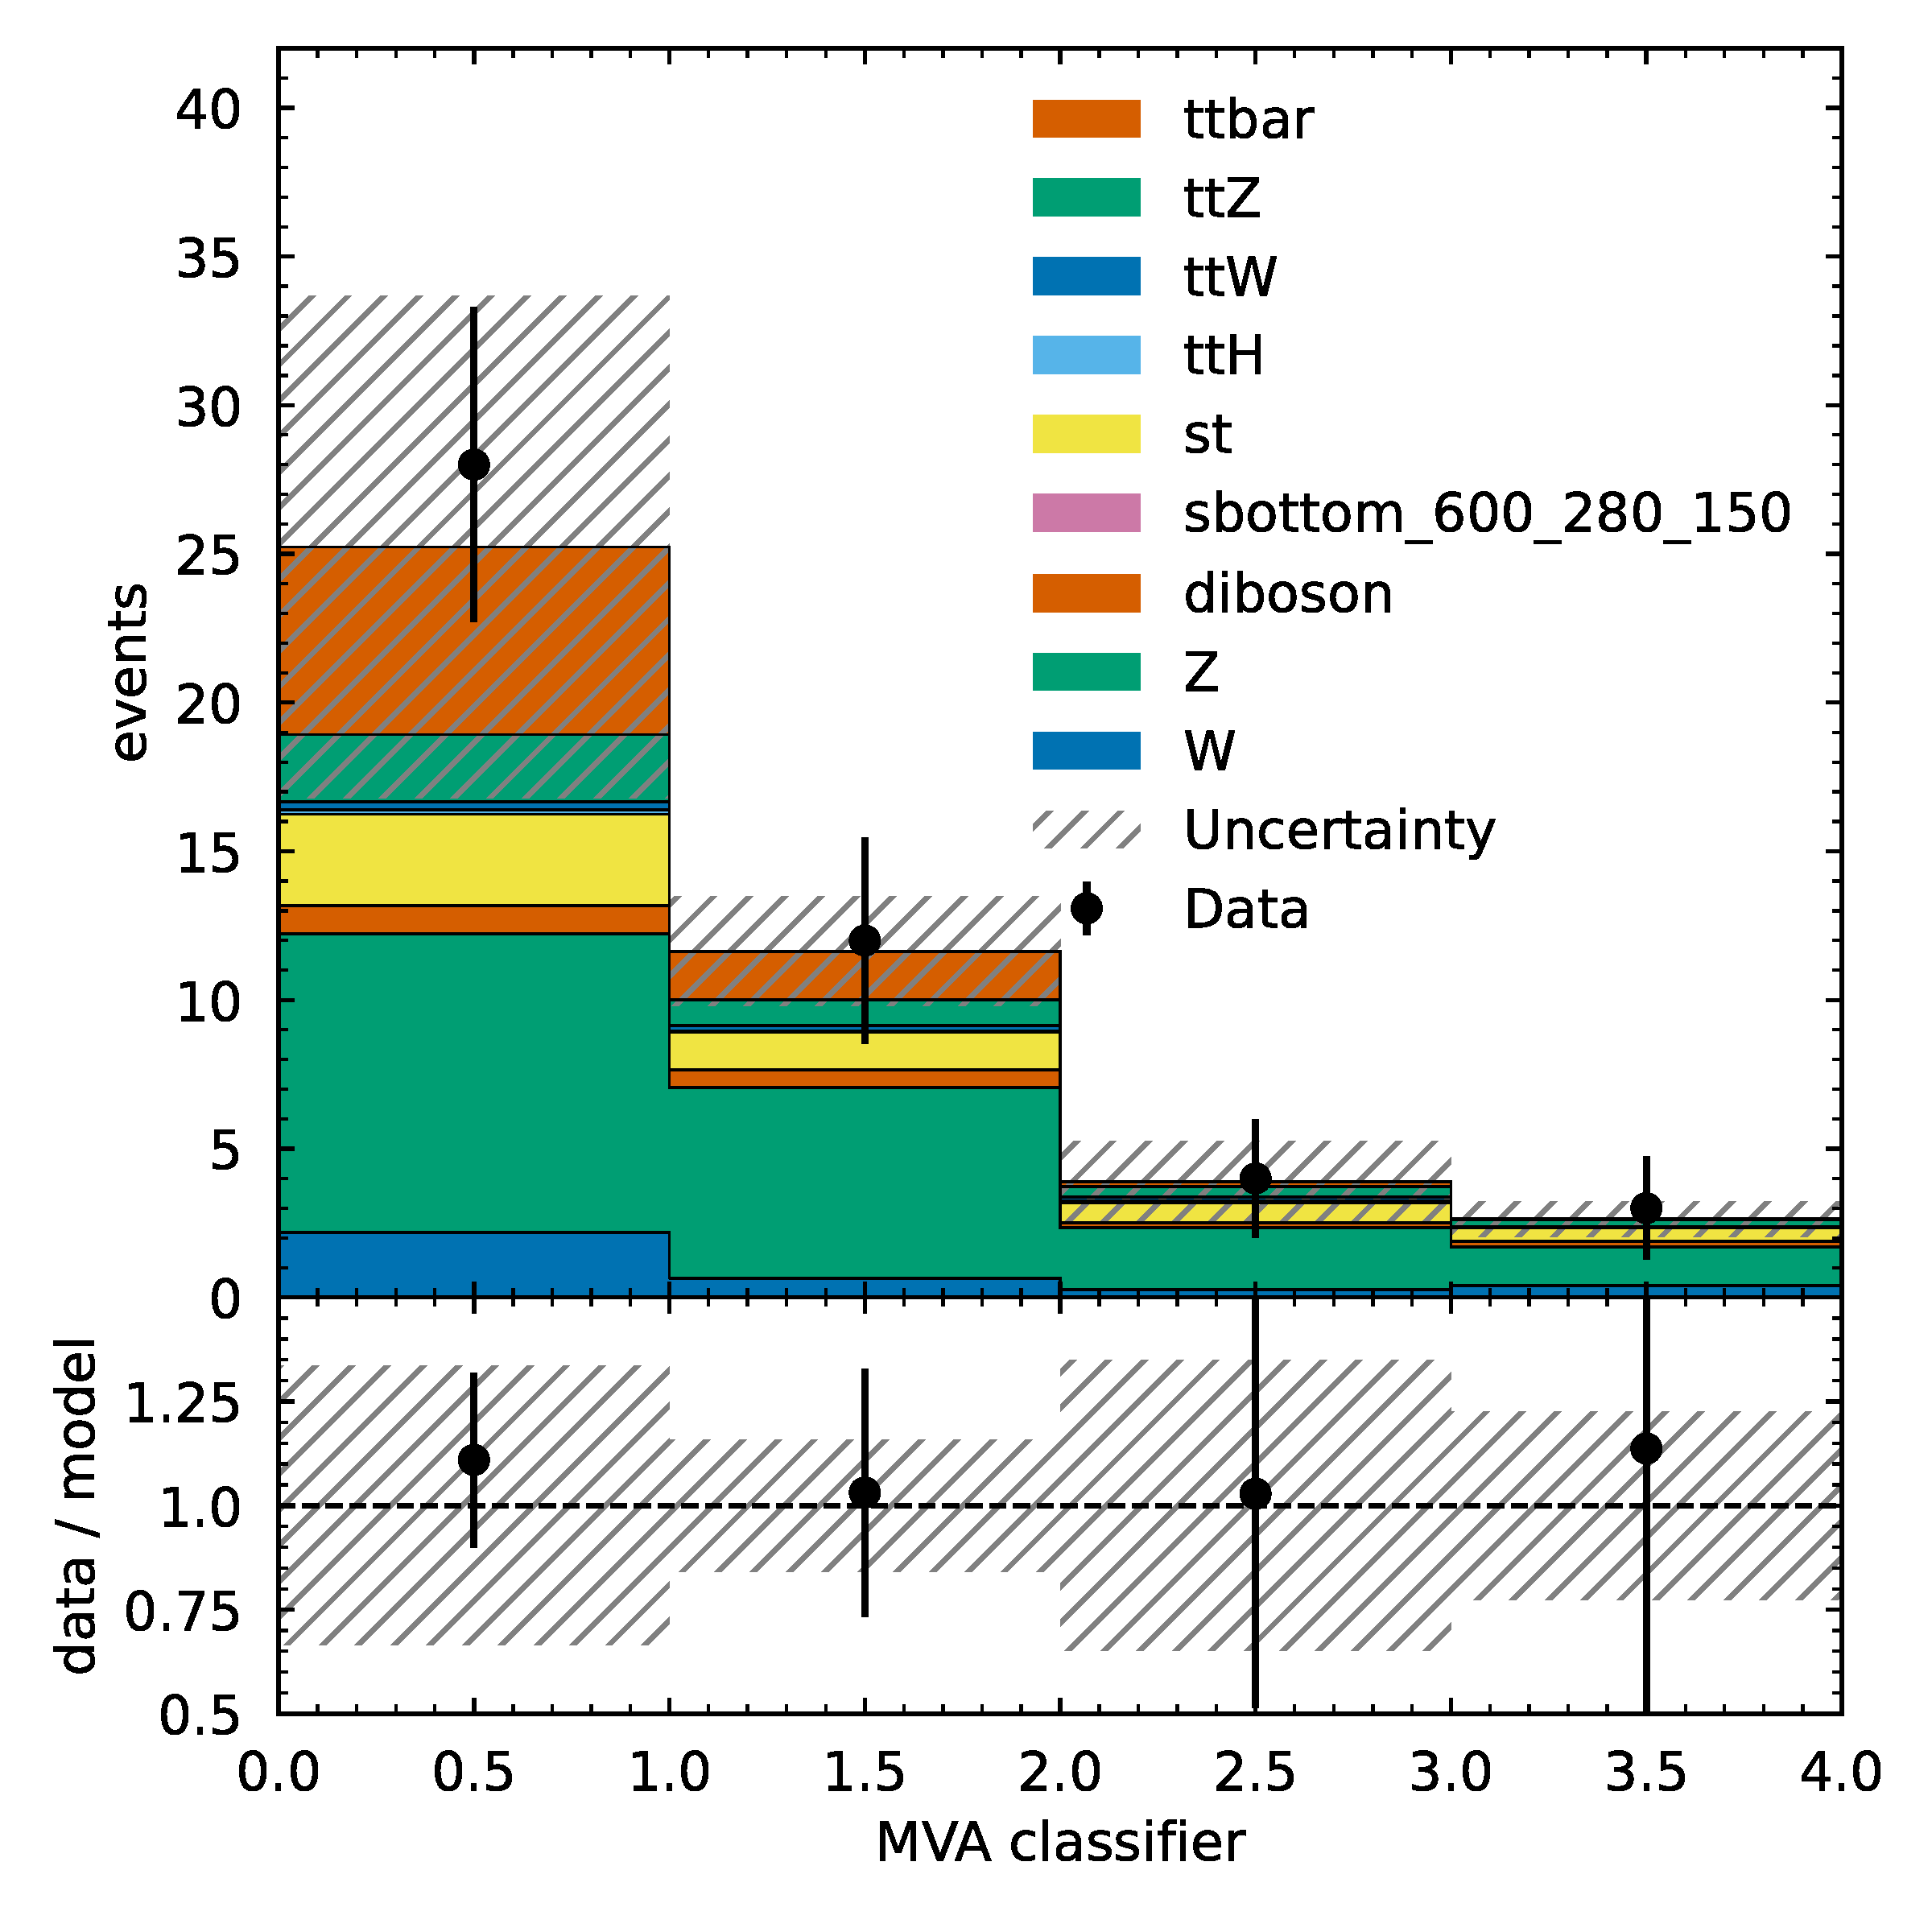

In [9]:
cabinetry.visualize.data_MC(model, data, fit_results=fit_results, include_table=False)
!gs -dSAFER -dBATCH -dNOPAUSE -dQUIET -sDEVICE=png16m -r400\
-sOutputFile="figures/SR_metsigST_postfit.png" "figures/SR_metsigST_postfit.pdf"
Image("figures/SR_metsigST_postfit.png", width=450)

The nuisance parameter pulls and correlations are visualized below.

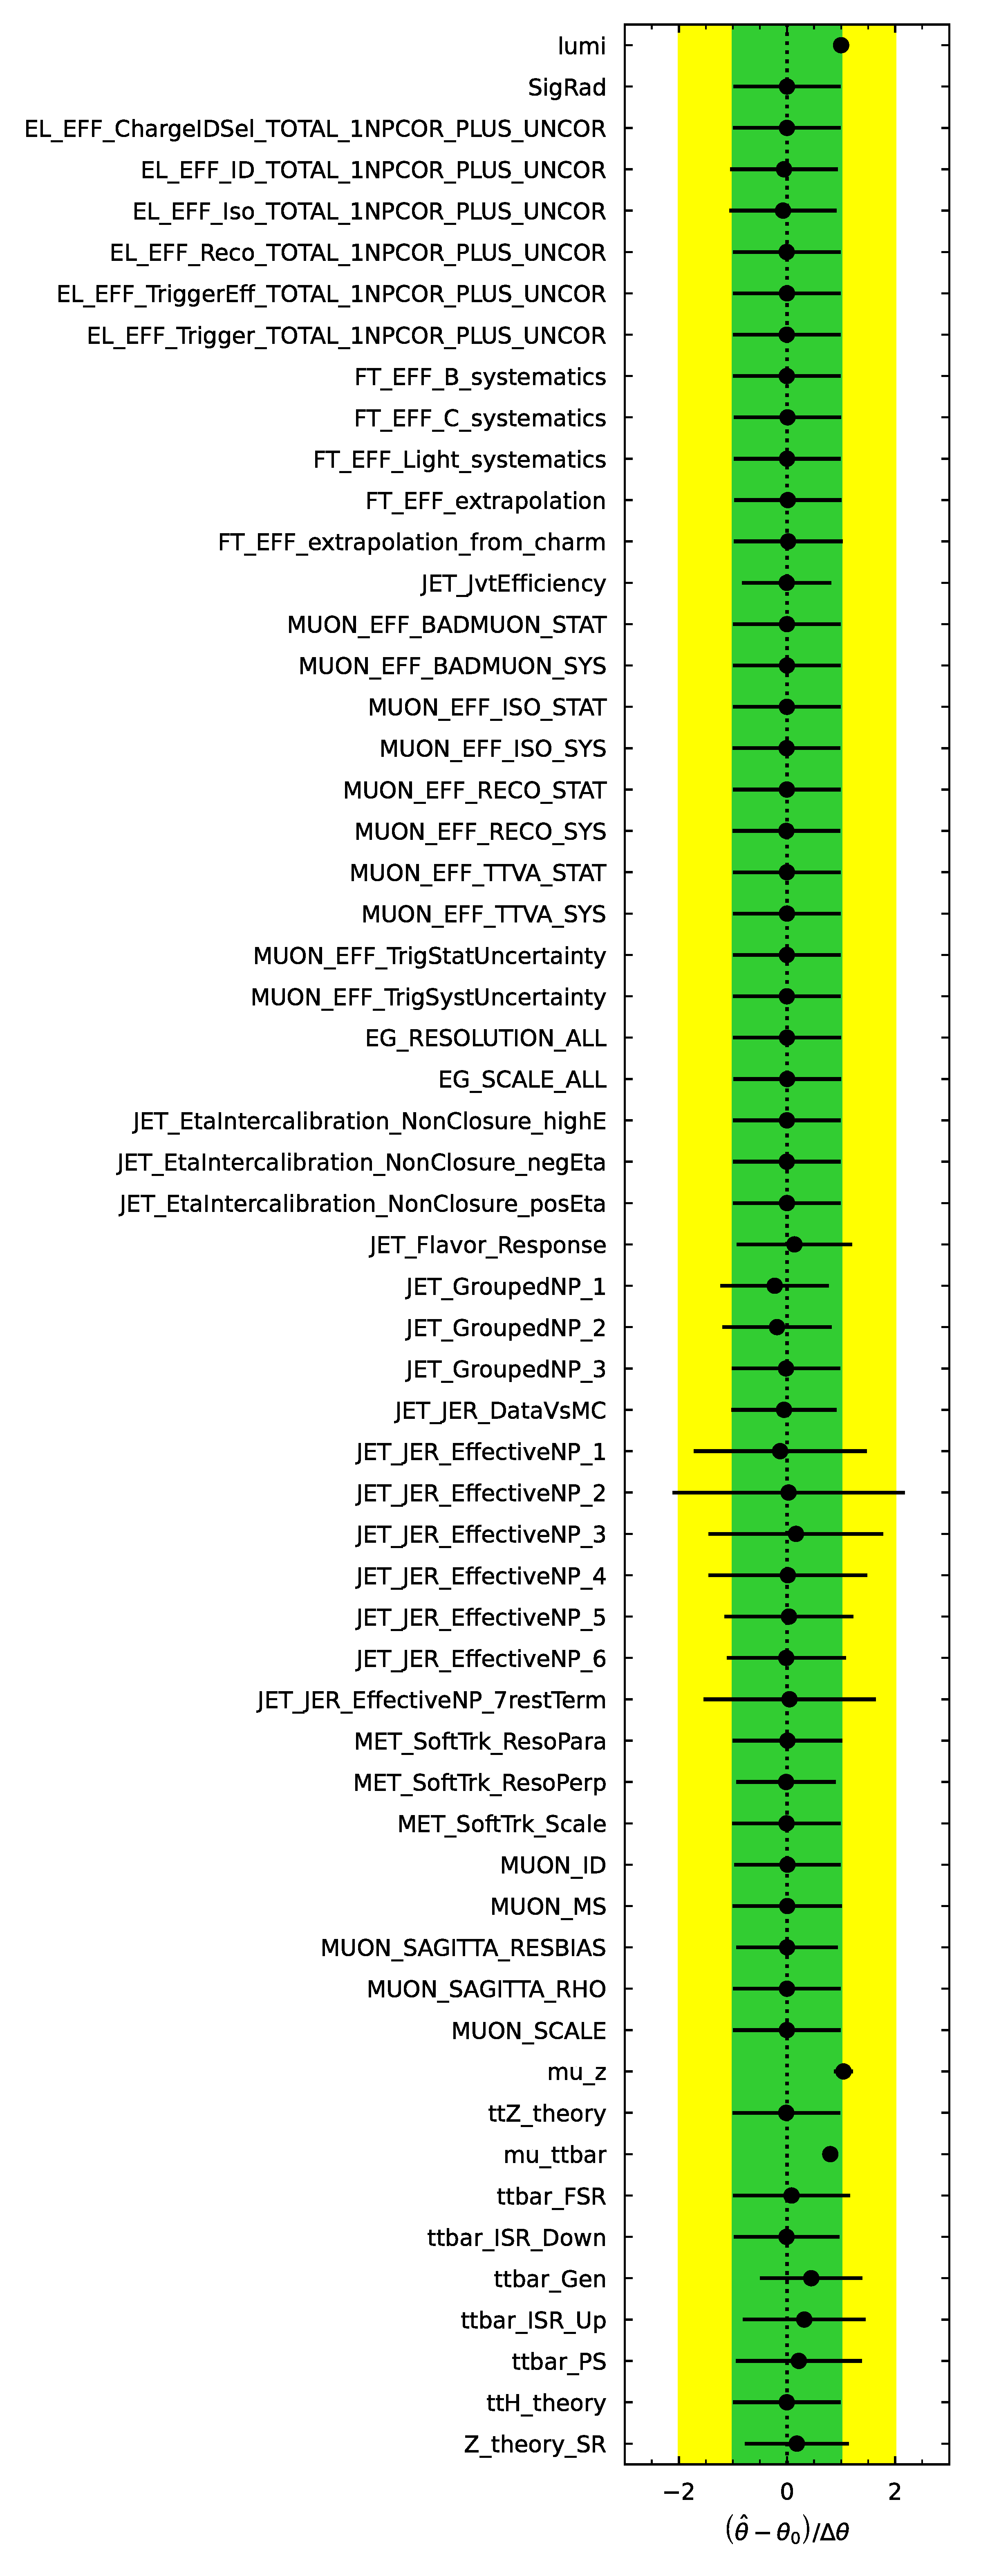

In [10]:
cabinetry.visualize.pulls(fit_results, exclude="mu_SIG")
!gs -dSAFER -dBATCH -dNOPAUSE -dQUIET -sDEVICE=png16m -r400 -sOutputFile="figures/pulls.png" "figures/pulls.pdf"
Image("figures/pulls.png", width=500)

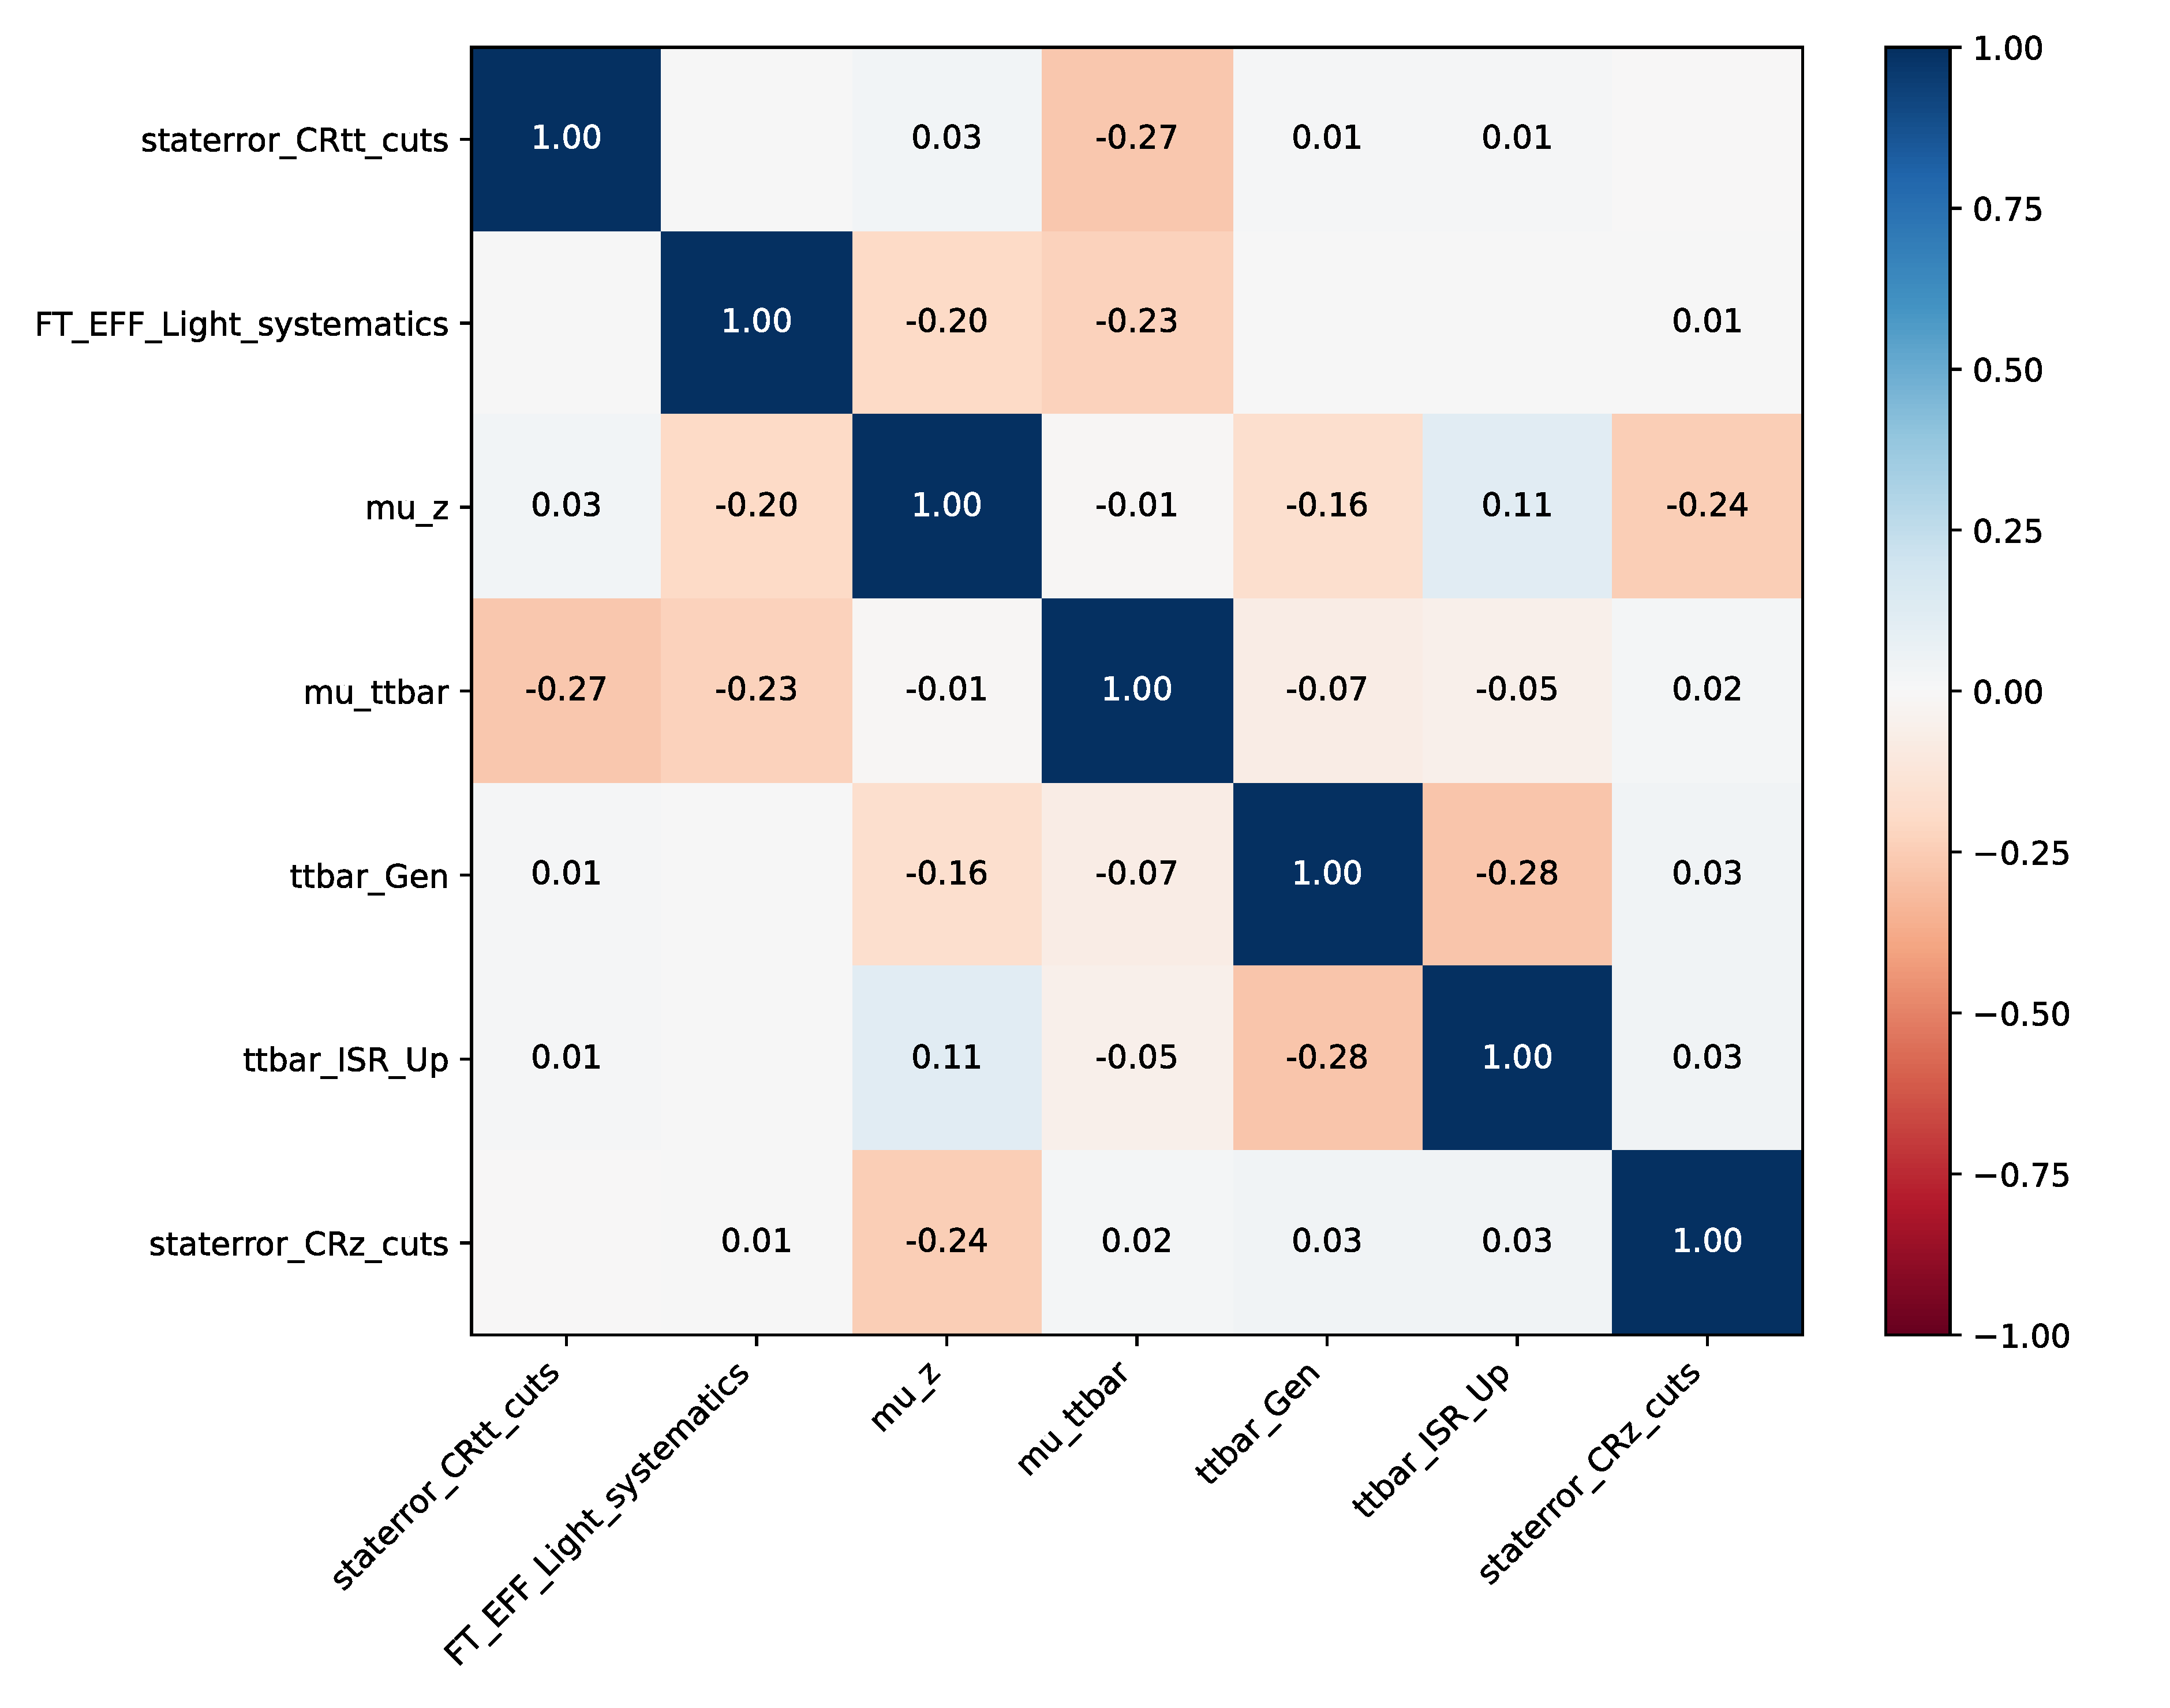

In [11]:
cabinetry.visualize.correlation_matrix(fit_results, pruning_threshold=0.2)
!gs -dSAFER -dBATCH -dNOPAUSE -dQUIET -sDEVICE=png16m -r400\
-sOutputFile="figures/correlation_matrix.png" "figures/correlation_matrix.pdf"
Image("figures/correlation_matrix.png", width=500)